# Variational Autoencoders - Fashion-MNIST

adapted from: https://keras.io/examples/generative/vae/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K

2023-08-30 11:07:22.689744: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 11:07:23.260495: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics
)

In [3]:
from scipy.stats import norm
from notebooks.utils import display

## Customize Setup

In [4]:
! pip install --no-index -f https://github.com/dreoporto/ptmlib/releases ptmlib

Looking in links: https://github.com/dreoporto/ptmlib/releases


In [5]:
from ptmlib.time import Stopwatch, AlertSounds
import ptmlib.charts as pch

In [6]:
main_stopwatch = Stopwatch()
main_stopwatch.start()

Start Time: Wed Aug 30 11:07:28 2023


## 0. Parameters

In [7]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 5000

## 1. Prepare the Data

In [8]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [9]:
def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype('float32') / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

In [10]:
x_train = preprocess(x_train)
x_test = preprocess(x_test)

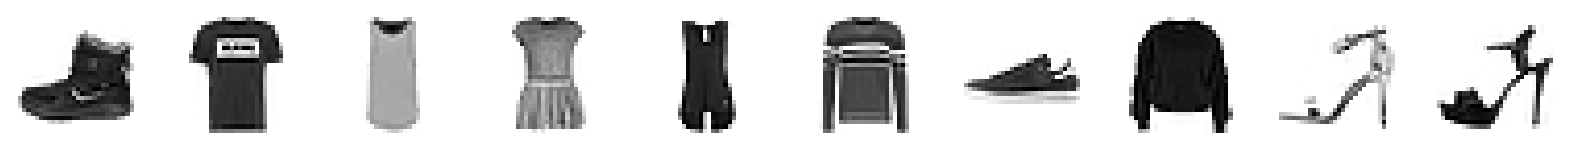

In [11]:
display(x_train)

## 2. Build the Variational Autoencoder

In [12]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Encoder

In [13]:
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name='encoder_input'
)

x = layers.Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
shape_before_flattening = K.int_shape(x)[1:] # used in decoder

x = layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM, name='z_mean')(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

2023-08-30 11:07:29.563525: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-30 11:07:29.584636: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-30 11:07:29.584913: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-30 11:07:29.586331: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 4, 4, 128)    73856       ['conv2d_1[0][0]']               
                                                                                            

ut NUMA support.
2023-08-30 11:07:29.588699: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-30 11:07:29.589051: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-30 11:07:31.471141: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-30 11:07:31.471676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-30 11:07:31.471694: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1700

### Decoder

In [14]:
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name='decoder_input')

x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)

x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)

decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation='sigmoid',
    padding='same',
    name='decoder_output'
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 32)       18464 

### VAE

In [15]:
class VAE(models.Model):

    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = metrics.Mean(name='kl_loss')

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]
    
    def call(self, inputs):
        """Call the model on a particular input"""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction
    
    def train_step(self, data):
        """Steps run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        """Step run during validation"""
        if isinstance(data, tuple):
            data = data[0]
        
        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5
                * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            'loss': total_loss,
            'reconstruction_loss': reconstruction_loss,
            'kl_loss': kl_loss
        }

In [16]:
vae = VAE(encoder, decoder)

## 3. Train the VAE

In [17]:
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [18]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath='./checkpoint',
    save_weights_only=False,
    save_freq='epoch',
    monitor='loss',
    mode='min',
    save_best_only=True,
    verbose=0
)

tensorboard_callback = callbacks.TensorBoard(log_dir='./logs')

In [19]:
stopwatch = Stopwatch()
stopwatch.start()

history = vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, y_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback]
)

stopwatch.stop()

Start Time: Wed Aug 30 11:07:32 2023
Epoch 1/5


2023-08-30 11:07:34.002367: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


600/600 [==============================] - 13s 14ms/step - total_loss: 1598.0732 - reconstruction_loss: 1588.2897 - kl_loss: 9.7830 - val_loss: 1365.6908 - val_reconstruction_loss: 1357.3361 - val_kl_loss: 8.3547
Epoch 2/5
600/600 [==============================] - 8s 13ms/step - total_loss: 1312.4041 - reconstruction_loss: 1303.9995 - kl_loss: 8.4040 - val_loss: 1330.2935 - val_reconstruction_loss: 1322.0164 - val_kl_loss: 8.2771
Epoch 3/5
600/600 [==============================] - 8s 13ms/step - total_loss: 1289.5870 - reconstruction_loss: 1281.3955 - kl_loss: 8.1916 - val_loss: 1314.7893 - val_reconstruction_loss: 1306.6278 - val_kl_loss: 8.1615
Epoch 4/5
600/600 [==============================] - 8s 13ms/step - total_loss: 1278.2115 - reconstruction_loss: 1270.1268 - kl_loss: 8.0843 - val_loss: 1302.7837 - val_reconstruction_loss: 1294.7880 - val_kl_loss: 7.9958
Epoch 5/5
600/600 [==============================] - 8s 14ms/step - total_loss: 1271.2482 - reconstruction_loss: 1263.184

Saved image: total_loss-20230830-110817.png


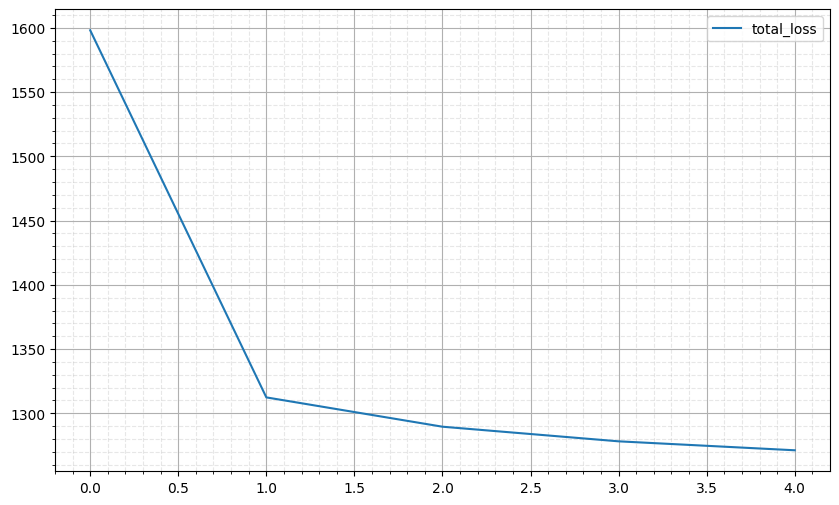

In [20]:
pch.show_history_chart(history, "total_loss", save_fig_enabled=True)

Saved image: loss-20230830-110817.png


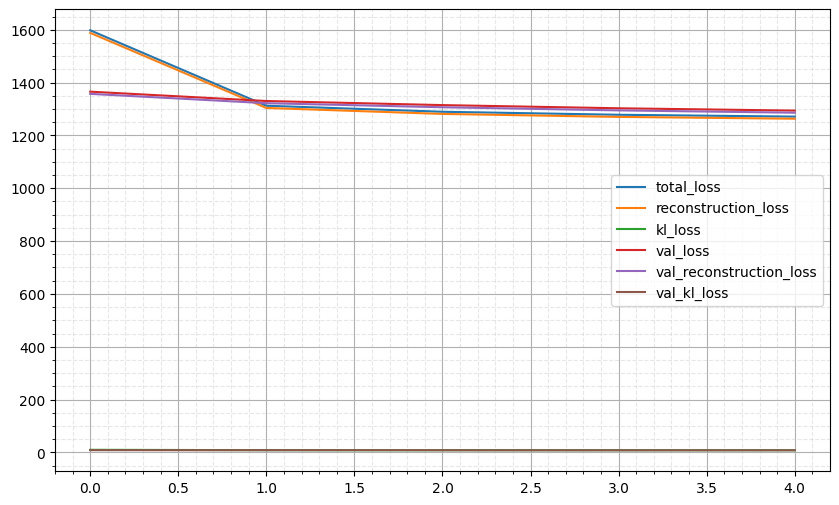

In [21]:
pch.show_history_chart(history, "loss", save_fig_enabled=True)

In [22]:
vae.save('./models/vae')
encoder.save('./models/encoder')
decoder.save('./models/decoder')

INFO:tensorflow:Assets written to: ./models/vae/assets


INFO:tensorflow:Assets written to: ./models/vae/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


### Reconstruct using the VAE

In [23]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 [==============================] - 1s 3ms/step
Example real clothing items


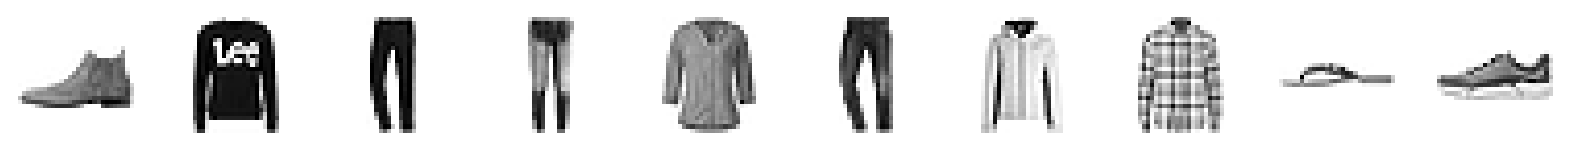

Reconstructions


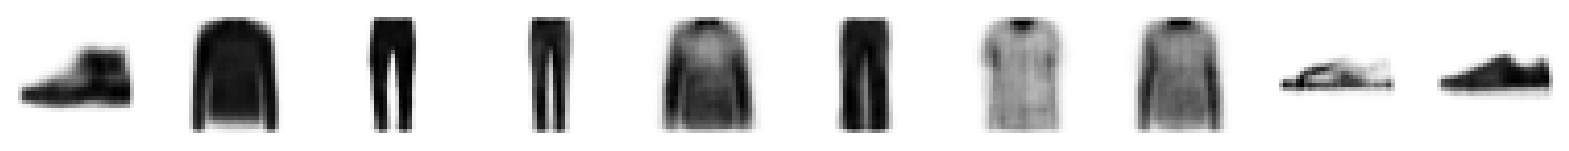

In [24]:
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print('Example real clothing items')
display(example_images)
print('Reconstructions')
display(reconstructions)

## 4. Embed using the encoder

In [25]:
# Encode the example images
z_mean, z_var, z = encoder.predict(example_images)

157/157 [==============================] - 0s 2ms/step


In [26]:
print(z[:10])

[[ 1.3313738   0.8459984 ]
 [-0.99817294 -0.7476391 ]
 [ 1.5046434  -4.016634  ]
 [ 1.8697745  -2.7615097 ]
 [-0.2320526  -0.27931827]
 [ 0.64250904 -2.6949112 ]
 [ 0.41941082 -0.68498707]
 [-0.05297226 -0.41068903]
 [ 2.6646485   2.019649  ]
 [ 1.7419922   1.9050273 ]]


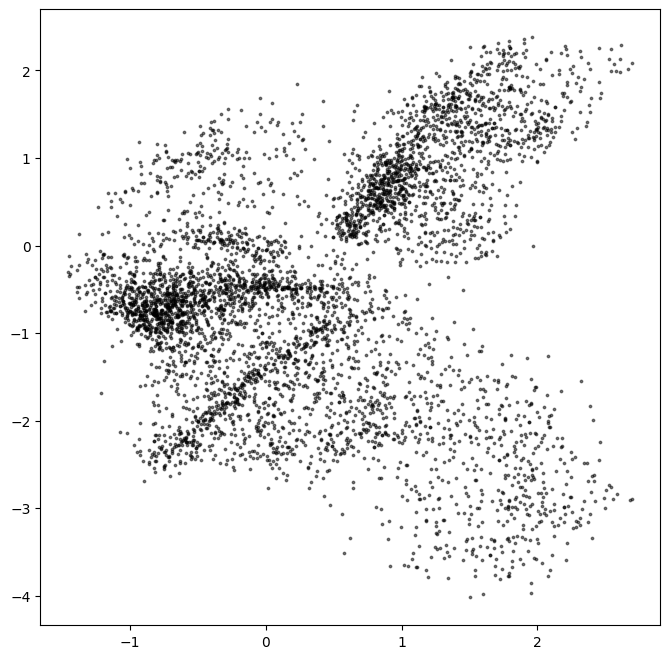

In [27]:
# show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c='black', alpha=0.5, s=3)
plt.show()

## 5. Generate using the decoder

In [28]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [29]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 121ms/step


In [30]:
# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

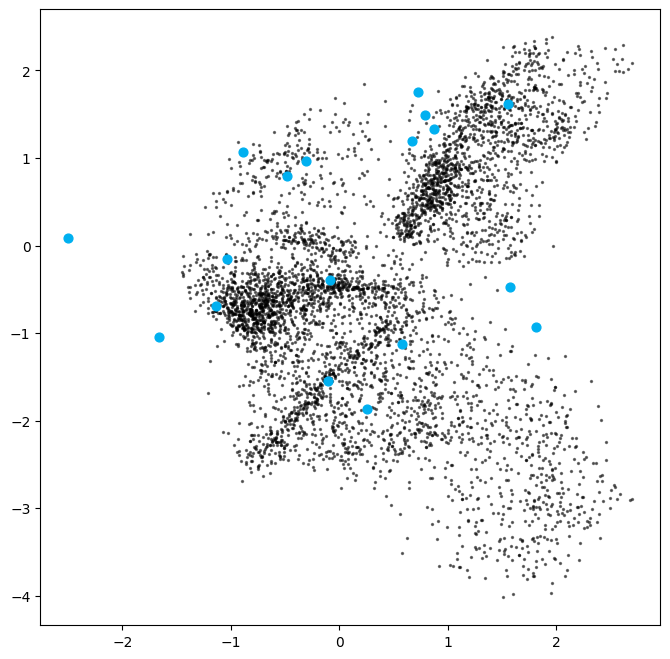

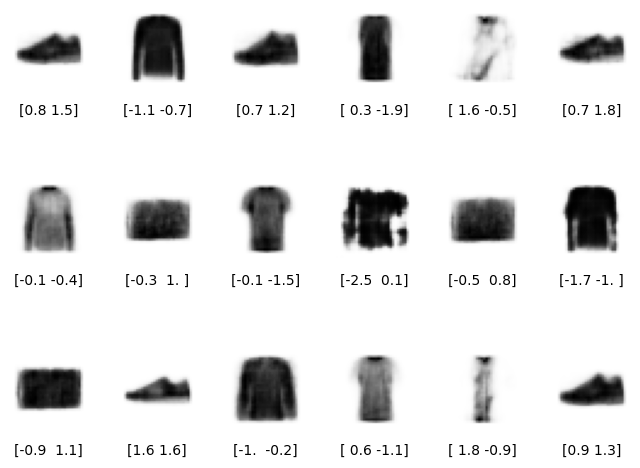

In [31]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c='black', alpha=0.5, s=2)

# and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c='#00B0F0', alpha=1, s=40)
plt.show()

## Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis('off')
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha='center',
        transform=ax.transAxes
    )
    ax.imshow(reconstructions[i, :, :], cmap='Greys')

## 6. Explore the latent space

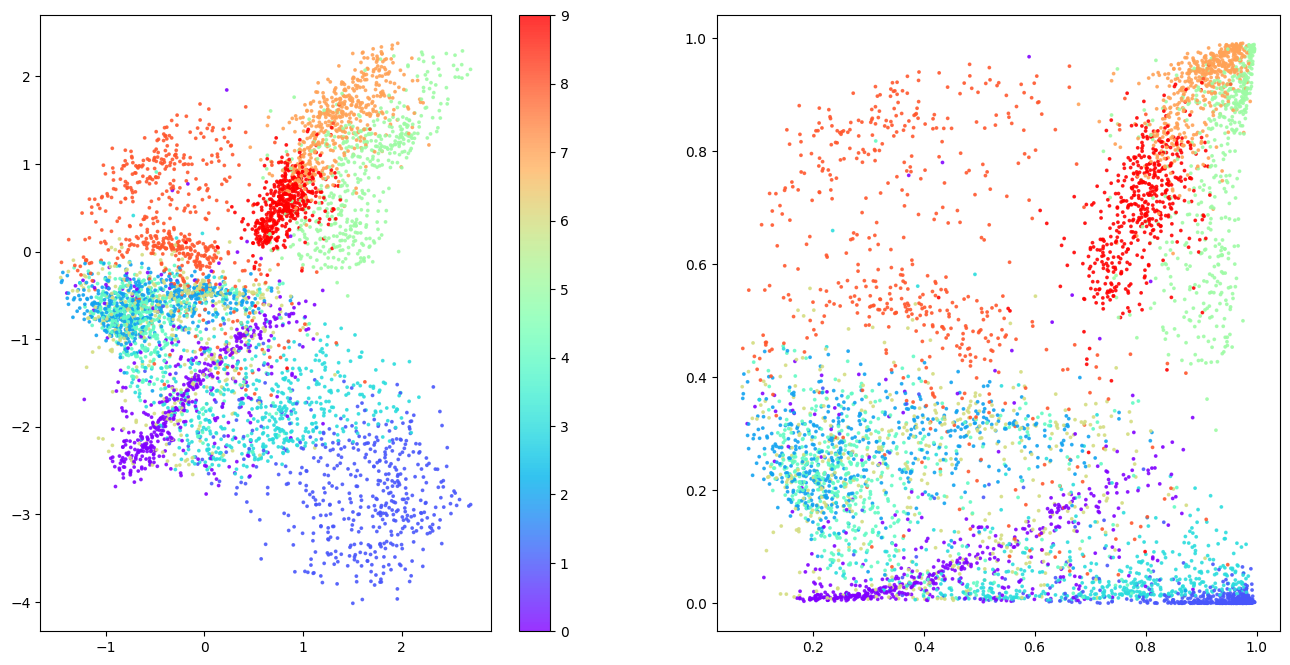

In [32]:
# Color the embeddings by their label (clothing type - see table)
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))

ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap='rainbow', c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)

ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap='rainbow', c=example_labels, alpha=0.8, s=3
)

plt.show()

| ID | Clothing Label |
| :- | :- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

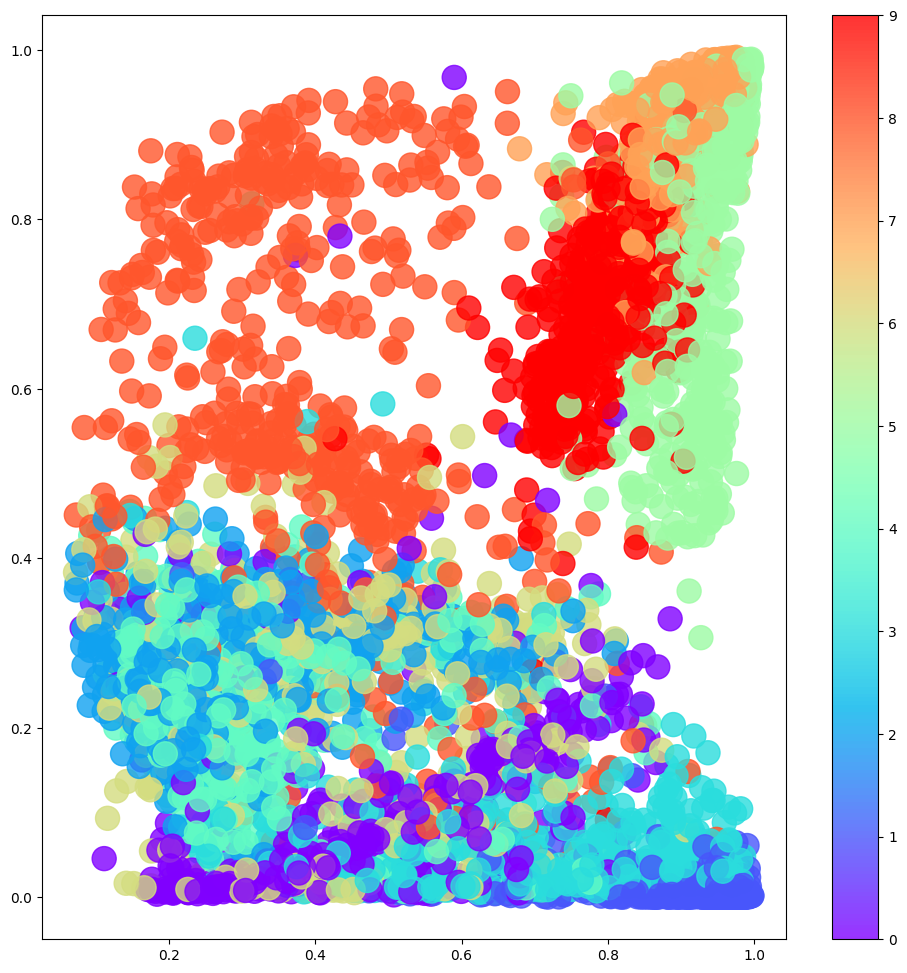

Start Time: Wed Aug 30 11:08:25 2023
Start Time: Wed Aug 30 11:08:25 2023
8/8 [==============================] - 0s 28ms/step
End Time:   Wed Aug 30 11:08:26 2023
Elapsed seconds: 0.2584 (0.00 minutes)
Start Time: Wed Aug 30 11:08:26 2023
End Time:   Wed Aug 30 11:08:28 2023
Elapsed seconds: 2.4027 (0.04 minutes)
End Time:   Wed Aug 30 11:08:28 2023
Elapsed seconds: 2.6628 (0.04 minutes)


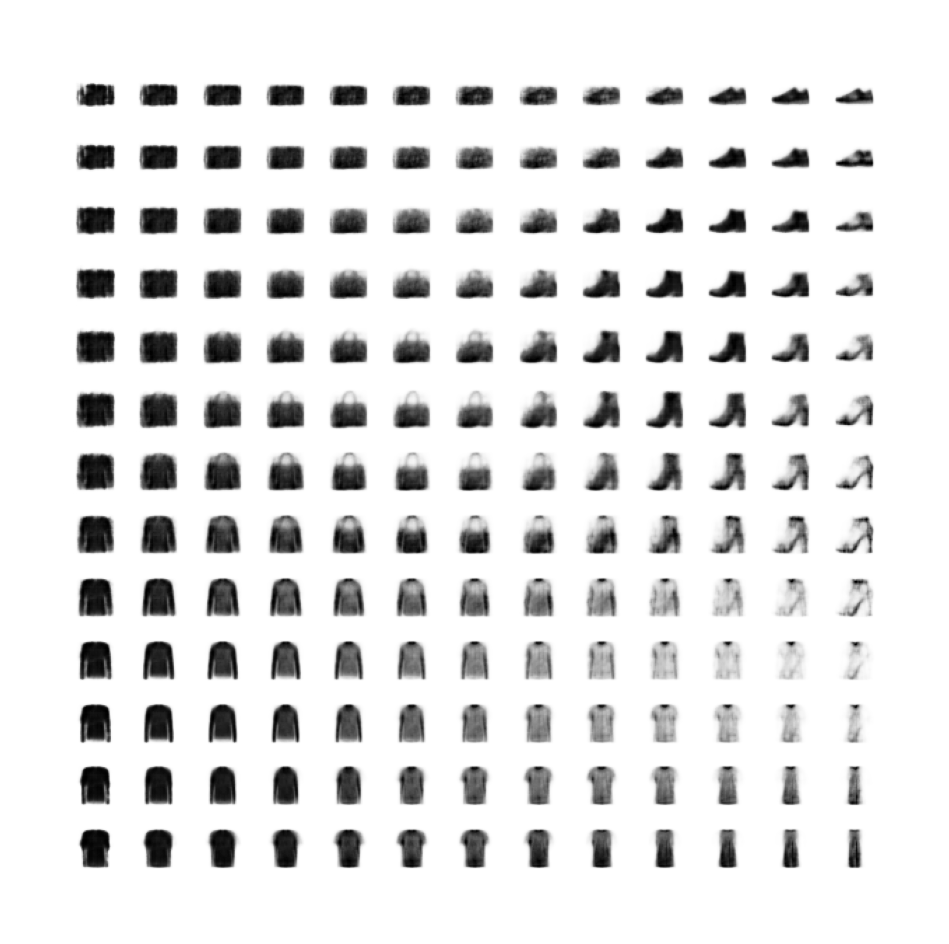

In [33]:
# color the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap='rainbow', c=example_labels, alpha=0.8, s=300
)
plt.colorbar()
plt.show()

# show images grid with evenly distributed examples

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

mid_stopwatch = Stopwatch()
mid_stopwatch.start()

stopwatch.start()
reconstructions = decoder.predict(grid)
stopwatch.stop()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
stopwatch.start()
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis('off')
    ax.imshow(reconstructions[i, :, :], cmap='Greys')
stopwatch.stop()

mid_stopwatch.stop()

In [34]:
# all done!
main_stopwatch.stop()

End Time:   Wed Aug 30 11:08:30 2023
Elapsed seconds: 61.9433 (1.03 minutes)
